# Projection on vertical modes

This notebook shows how to use the module and class vmodes for computing vertical modes and projecting/reconstructing dynamical fields in a CROCO Run.

The procedure is as follows:
* Load simulation using postp.Run
* compute mean stratification
* compute vertical modes using vmodes.Vmodes
* project, reconstruct, ...
* store vertical modes and projections

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import xarray as xr
from xgcm import Grid

import crocosi.postp as pp
import crocosi.gridop as gop
import crocosi.vmodes as vmd

# Load simulation and compute mean stratification
loading simulation from netcdf files using postp Run class

In [2]:
### Load simulation

root_path = '/home/datawork-lops-osi/equinox/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'
    
it = 1 # time index (working with one time index for this example)

r = pp.Run(root_path+run, prefix='file_',open_nc=['grid','his'], verbose=False)
ds = r['his'].isel(time=it)

## First example: single horizontal point. 
N2 is the average over a portion of the domain

In [3]:
### select sub-dataset for defining mean stratif
nx, ny = 100, 100
sds = ds.isel(x_rho=range(nx), y_rho=range(ny))

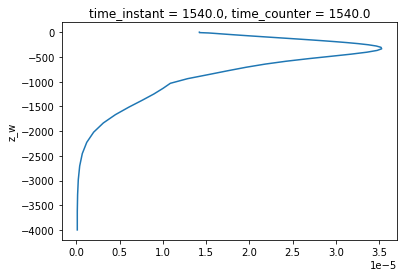

In [4]:
### Compute mean quantities:

ssh_mean = sds.ssh_a.mean()
h_mean = r['grid'].h.isel(x_rho=range(nx), y_rho=range(ny)).mean()

zr_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='r', hgrid='r')
zw_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='w', hgrid='r')

z_rho = r.get_z(zeta=sds.ssh_a, vgrid="r", hgrid="r")
T_mean = gop.interp2z(zr_mean, z_rho, sds.T_a).mean(["x_rho","y_rho"]) # interpolate on mean grid
N2 = r.get_N2(T_mean, zr_mean).chunk({"s_w":-1}) # compute stratif
N2 = N2.assign_coords(z_w=zw_mean).persist()

N2.plot(y="z_w")

### Compute vertical modes

Vmode object with dimensions ('mode', 's_rho', 's_w')
  Number of modes = 10
  N2, min/max = 1.2e-07, 3.5e-05
  Options / parameters: grav: 9.81, free_surf: True, eig_sigma: 1.0e-01

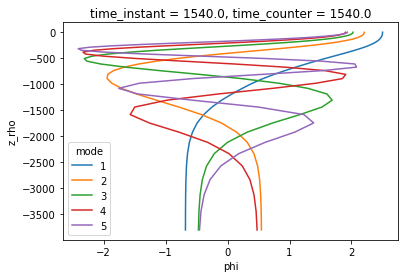

In [5]:
### compute modes
nmodes = 10

### we need to define a xgcm grid
gridcoord = {key:val.coords for key,val in r.xgrid.axes.items() if key not in ["xi", "eta"]}
xgrid = Grid(sds, coords=gridcoord, periodic=False)

vmodes = vmd.Vmodes(xgrid, zr_mean, zw_mean, N2, nmodes, persist=False) 

### plot and show results
vmodes['phi'].sel(mode=slice(1,5)).plot.line(y="z_rho", hue='mode') 

### display vmodes content
vmodes

### Project and reconstruct at a single point (pressure and vertical velocity)

Text(0.5, 1.0, 'w_cos')

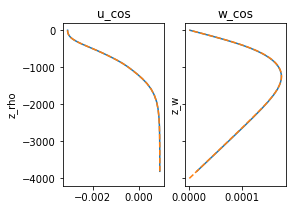

In [6]:
jy, ix = 10, 20 # isel in sds
subds = sds.isel(y_rho=jy, x_rho=ix, x_u=ix) # x_u=ix is an approximate shortcut...

h0 = r.ds['grid'].h.sel(x_rho=subds.x_rho, y_rho=subds.y_rho)
z_r = r.get_z(zeta=subds.ssh_a, h=h0, hgrid="r", vgrid="r")

### project
un = vmodes.project(subds.u_t_cos, "p", align=True, z=z_r)
wn = vmodes.project_w(subds.w_t_cos, align=True, z=z_r)
### and reconstruct
u_rec = vmodes.reconstruct(un, "u")
w_rec = vmodes.reconstruct(wn, "w")

### plot result
fig, axs = plt.subplots(1, 2, figsize=(4,3), sharey=True)
subds.u_t_cos.assign_coords(z_rho=z_r).plot(y="z_rho", ax=axs[0], label="true")
u_rec.plot(y="z_rho", ax=axs[0], label="reco", linestyle="--")
axs[0].set_title('u_cos')

subds.w_t_cos.assign_coords(z_rho=z_r).plot(y="z_rho", ax=axs[1], label="true")
vmodes.reconstruct_w(wn).plot(y="z_w", ax=axs[1], label="reco", linestyle="--")
axs[1].set_title('w_cos')

#### minor disgression: storing and loading vertical modes and projections

In [7]:
# store
ds_proj = xr.merge([un.rename('u'), wn.rename('w')])
r.store_vmodes('vmodes_1d', vmodes, projections=ds_proj, mode='w')

Store vertical modes in /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/diagnostics/vmodes_1d.zarr
Store projections in /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/diagnostics/vmodes_1d_projections.zarr


In [8]:
#ds = xr.open_zarr('/home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/diagnostics/vmodes_1d.zarr')

<xarray.Dataset>
Dimensions:  (mode: 11)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    u        (mode) float64 dask.array<chunksize=(11,), meta=np.ndarray>
    w        (mode) float64 dask.array<chunksize=(11,), meta=np.ndarray>
Attributes:
    s_w:           0.0
    time_counter:  1540.0
    time_instant:  1540.0
    x_rho:         78000.0
    x_u:           80000.0
    x_v:           78000.0
    y_rho:         38000.0
    y_u:           38000.0

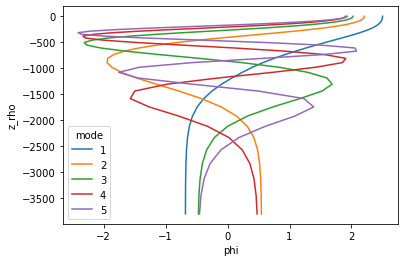

In [9]:
vmodes_loaded, ds_proj_loaded = r.load_vmodes('vmodes_1d', persist=True)
vmodes_loaded['phi'].sel(mode=slice(1,5)).plot.line(y="z_rho", hue='mode')
ds_proj_loaded

## 2nd example: vertical modes are $y$-dependent

Mean stratif is an average along $x$

In [23]:
### select portion of dataset
sliy = slice(100, -100, 2)
sds = ds.isel(y_rho=sliy)

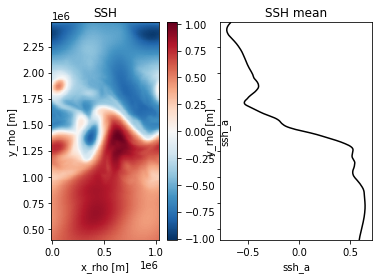

In [24]:
### compute and plot mean ssh (and vertical levels)
ssh_mean = sds.ssh_a.mean(dim='x_rho')
h_mean = r['grid'].h.isel(y_rho=sliy).mean(dim="x_rho")
    
fig, axs = plt.subplots(1, 2, sharey=True)
sds.ssh_a.plot(ax=axs[0])
ssh_mean.plot(ax=axs[1], y="y_rho", color="k")
axs[0].set_aspect('equal')
axs[0].set_title('SSH')
axs[1].set_title('SSH mean')

# and compute mean vertical grids
zr_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='r', hgrid='r').persist()
zw_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='w', hgrid='r').persist()

/home1/datahome/aponte/croco/crocosi/gridop.py:186: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(*reordered_dims)
/home1/datahome/aponte/croco/crocosi/gridop.py:533: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  vout = vout.transpose(*output_dims)


Text(0.5, 1.0, 'mean N2')

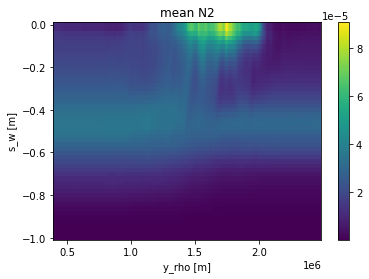

In [25]:
# compute mean stratification
z_rho = r.get_z(zeta=sds.ssh_a, vgrid="r", hgrid="r")
T_mean = gop.interp2z(zr_mean, z_rho, sds.T_a).mean("x_rho") # interpolate on mean grid
N2 = r.get_N2(T_mean, zr_mean).chunk({"s_w":-1}) # compute stratif
N2 = N2.assign_coords(z_w=zw_mean).persist()

### plot result    
N2.plot(y="s_w")
plt.title("mean N2")

### compute vertical modes

Vmode object with dimensions ('mode', 's_rho', 's_w', 'y_rho')
  Number of modes = 8
  N2, min/max = 1.0e-07, 9.1e-05
  Options / parameters: grav: 9.81, free_surf: True, eig_sigma: 1.0e-01

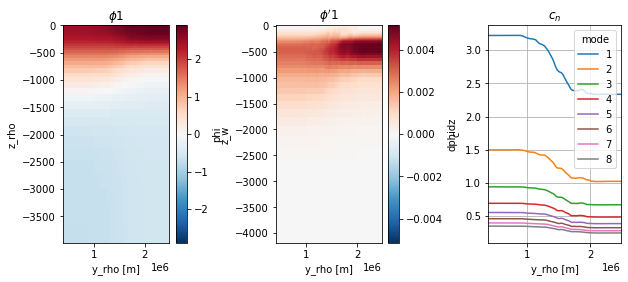

In [26]:
### compute modes
nmodes = 8

# create xgcm grid
gridcoord = {key:val.coords for key,val in r.xgrid.axes.items() if key not in "xi"}
xgrid = Grid(sds, coords=gridcoord, periodic=['eta'])
    
vmodes = vmd.Vmodes(xgrid, zr_mean, zw_mean, N2, nmodes, persist=True) # working version

# plot result (for one mode)
imod = 1
fig, axs = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(10,4))
vmodes.ds.phi.sel(mode=imod).plot(x="y_rho", y="z_rho", ax=axs[0])
axs[0].set_title(r"$\phi $"+str(imod))
vmodes.ds.dphidz.sel(mode=imod).plot(x="y_rho", y="z_w", ax=axs[1])
axs[1].set_title(r"$\phi' $"+str(imod))
vmodes.ds.c.isel(mode=slice(1,None)).plot.line(x="y_rho", ax=axs[2])
axs[2].grid(True)
axs[2].set_title(r"$c_n$")
fig.subplots_adjust(wspace=.6)

# show result
vmodes

### Project and reconstruct at a single point (pressure and vertical velocity)

/home1/datahome/aponte/croco/crocosi/gridop.py:533: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  vout = vout.transpose(*output_dims)
/home1/datahome/aponte/croco/crocosi/gridop.py:533: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  vout = vout.transpose(*output_dims)


Text(0.5, 1.0, 'w_cos')

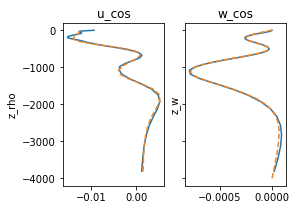

In [27]:
jy, ix = 100, 0 # isel in sds
subds = sds.isel(y_rho=[jy], x_rho=ix, x_u=ix) # x_u=ix is an approximate shortcut...

h0 = r.ds['grid'].h.isel(x_rho=ix).sel(y_rho=subds.y_rho)
z_r = r.get_z(zeta=subds.ssh_a, h=h0, hgrid="r", vgrid="r")

### project
un = vmodes.project(subds.u_t_cos, "p", align=True, z=z_r)
wn = vmodes.project_w(subds.w_t_cos, align=True, z=z_r)
### and reconstruct
u_rec = vmodes.reconstruct(un, "u")
w_rec = vmodes.reconstruct(wn, "w")

### plot result
fig, axs = plt.subplots(1, 2, figsize=(4,3), sharey=True)
subds.u_t_cos.assign_coords(z_rho=z_r).plot(y="z_rho", ax=axs[0], label="true")
u_rec.plot(y="z_rho", ax=axs[0], label="reco", linestyle="--")
axs[0].set_title('u_cos')

subds.w_t_cos.assign_coords(z_rho=z_r).plot(y="z_rho", ax=axs[1], label="true")
vmodes.reconstruct_w(wn).plot(y="z_w", ax=axs[1], label="reco", linestyle="--")
axs[1].set_title('w_cos')

### Project horizontal velocity (2D modal amplitude)

/home1/datahome/aponte/croco/crocosi/gridop.py:533: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  vout = vout.transpose(*output_dims)


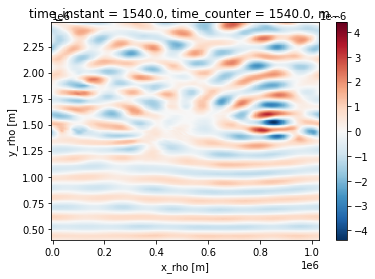

In [28]:
### project on the full domain and plot modal amplitude

imod = 1

un = vmodes.project(sds.w_t_cos, "w", align=True, z=z_rho, sel={"mode":imod})

un.plot()


## store and reload vmodes and projections

In [29]:
vmodes

Vmode object with dimensions ('mode', 's_rho', 's_w', 'y_rho')
  Number of modes = 8
  N2, min/max = 1.0e-07, 9.1e-05
  Options / parameters: grav: 9.81, free_surf: True, eig_sigma: 1.0e-01